# training

输入：xyz<br>
输出：三路压强

均值为0且归一化至(-0.5,0.5)，采用多隐含层进行训练

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import csv
import copy
import torch
from sklearn.preprocessing import MinMaxScaler

In [2]:
import os #导入os模块
os.getcwd() #得到当前工作目录

'd:\\Robotics Laboratory\\Esnake\\damper_paper_2-main\\code&data\\code\\model_training'

In [3]:
TRAINING_SET = '../../training_sets/No1and2x22.csv' # training set
training_set = 'No1and2x22'
MODEL_PATH = './models'
TEST_FILE  = '../../test_sets/No3x4.csv' # testing set
FIG_PATH = './figures'

Hyperparameters

In [4]:
hidden_size = 32            # neuron个数
num_epochs = 10000          # 训练轮数
learning_rate = 0.001       # 使用的学习率
momentum = 0.9              # SGD的momentum
num_layers = 3              # 隐含层个数

读取训练集数据并归一化

In [5]:
# create an empty list to hold the sequences
training_data = []

# read the CSV file and split it into sequences
with open(TRAINING_SET, newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        if row[0] == '':  # empty row indicates end of sequence
            continue
        else:
            # convert the row to a list of floats and append to the sequence
            row_float = [float(x) for x in row]
            training_data.append(row_float)

print('training_data size:', len(training_data), 'x', len(training_data[0]))

training_data size: 2160 x 6


In [6]:
# normalize the data between -0.5 and 0.5
scaler = MinMaxScaler(feature_range=(-0.5, 0.5))
scaled_data = scaler.fit_transform(training_data)

# convert the data to a torch tensor
normalized_data = torch.tensor(scaled_data, dtype=torch.float32)

# Separate the inputs and targets
x = normalized_data[:, 3:]
y = normalized_data[:, :3]
x = x.unsqueeze(0)
y = y.unsqueeze(0)

In [7]:
# GPU 加速
device = torch.device("cpu")
 
x = x.to(device)
y = y.to(device)

In [8]:
# 定义FNN
class Net(torch.nn.Module):
    def __init__(self,nfeature,n,n_output):
        super(Net, self).__init__()
        self.hidden1=torch.nn.Linear(nfeature,int(n/2))
        self.hidden2=torch.nn.Linear(int(n/2),n)
        self.hidden3=torch.nn.Linear(n,int(n/2))
        self.predict=torch.nn.Linear(int(n/2),n_output)
 
    def forward(self,x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = torch.relu(self.hidden3(x))
        x = self.predict(x)
        return x
    
# Define loss function
loss_func = torch.nn.L1Loss()

In [9]:
# Define optimizer
loss_descent = np.zeros(num_epochs)
net = Net(3,hidden_size,3).to(device)
optim = torch.optim.SGD(net.parameters(),lr=learning_rate,momentum=momentum)
for j in range(num_epochs):
    if j == int(num_epochs*3/4): # 3/4*epoch 后学习率降到0.0001
        optim = torch.optim.SGD(net.parameters(),lr=0.0005,momentum=momentum)
    print('Epoch: %d'%j, end='\r')   
        
    prediction = net(x.to(torch.float32))    
    loss = loss_func(prediction,y.to(torch.float32))
    optim.zero_grad()
    loss.backward()
    optim.step()
    loss_descent[j] = loss
    if j % 2000 == 1999:    # print every 2000 mini-batches
        print('\r[%d, %5d] loss: %.8f' %
            (num_epochs, j + 1, loss))

MODEL = MODEL_PATH+'/FNN_'+ str(training_set)+'_'+str(learning_rate)+'_'+str(hidden_size)+'_'+str(num_epochs)+'_'+str(num_layers)+'.pth'
torch.save(net.state_dict(), MODEL)

[10000,  2000] loss: 0.11678059
[10000,  4000] loss: 0.08214031
[10000,  6000] loss: 0.07610308
[10000,  8000] loss: 0.07444838
[10000, 10000] loss: 0.07354753


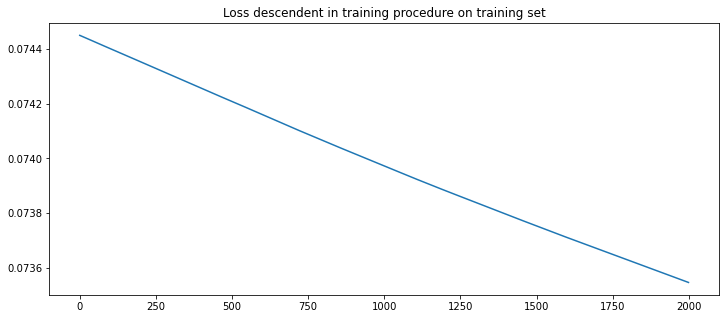

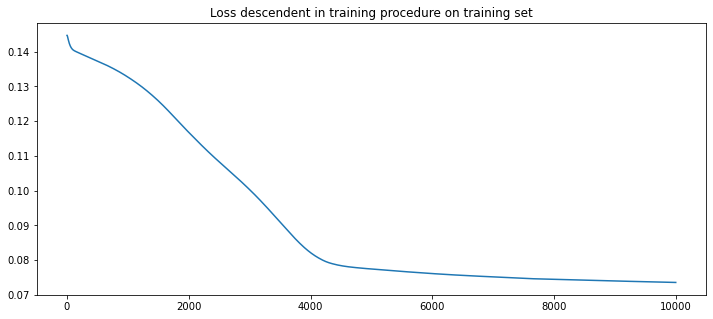

Quater final loss is:  0.10826802253723145
Semi final loss is:  0.07742348313331604
Final loss is:  0.07354752719402313


In [10]:
plt.figure(figsize=(12,5))
t = np.arange(num_epochs)
t_part = np.arange(2000)
# plt.plot(t,loss_descent)
plt.plot(t_part,loss_descent[-2001:-1])
plt.title('Loss descendent in training procedure on training set')
plt.show()

plt.figure(figsize=(12,5))
plt.plot(t,loss_descent)
plt.title('Loss descendent in training procedure on training set')
plt.show()

print('Quater final loss is: ', loss_descent[int(num_epochs/4)])
print('Semi final loss is: ', loss_descent[int(num_epochs/2)])
print('Final loss is: ',loss_descent[num_epochs-1])

Test data pre-process

In [11]:
# create an empty list to hold the sequences
test_data = []

# read the CSV file and split it into sequences
with open(TEST_FILE, newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        if row[0] == '':  # empty row indicates end of sequence
            continue
        else:
            # convert the row to a list of floats and append to the sequence
            row_float = [float(x) for x in row]
            test_data.append(row_float)

print('test_data size:', len(test_data), 'x', len(test_data[0]))

test_data size: 184 x 6


In [12]:
# normalize the data between -0.5 and 0.5
scaled_data_t = scaler.transform(test_data)

# convert the data to a torch tensor
normalized_data_t = torch.tensor(scaled_data_t, dtype=torch.float32)

# Separate the inputs and targets
x_t = normalized_data_t[:, 3:]
y_t = normalized_data_t[:, :3]
x_t = x_t.unsqueeze(0)
y_t = y_t.unsqueeze(0)

print('normalized_data_t size:', normalized_data_t.size())

normalized_data_t size: torch.Size([184, 6])


In [13]:
model = Net(3,hidden_size,3)
model.load_state_dict(torch.load(MODEL, map_location='cpu'))
model.eval()

Net(
  (hidden1): Linear(in_features=3, out_features=16, bias=True)
  (hidden2): Linear(in_features=16, out_features=32, bias=True)
  (hidden3): Linear(in_features=32, out_features=16, bias=True)
  (predict): Linear(in_features=16, out_features=3, bias=True)
)

In [14]:
# Prediction on the test data
prediction = model(x_t.to(torch.float32))
prediction = prediction.detach().numpy()

In [15]:
# reshape the data into dimensions 6
data_p = np.zeros(normalized_data_t.shape)
data_p[:, :3] = prediction

# De-normalize the data between -0.5 and 0.5
data_p = scaler.inverse_transform(data_p)

print('data_p size:', data_p.shape)

data_p size: (184, 6)


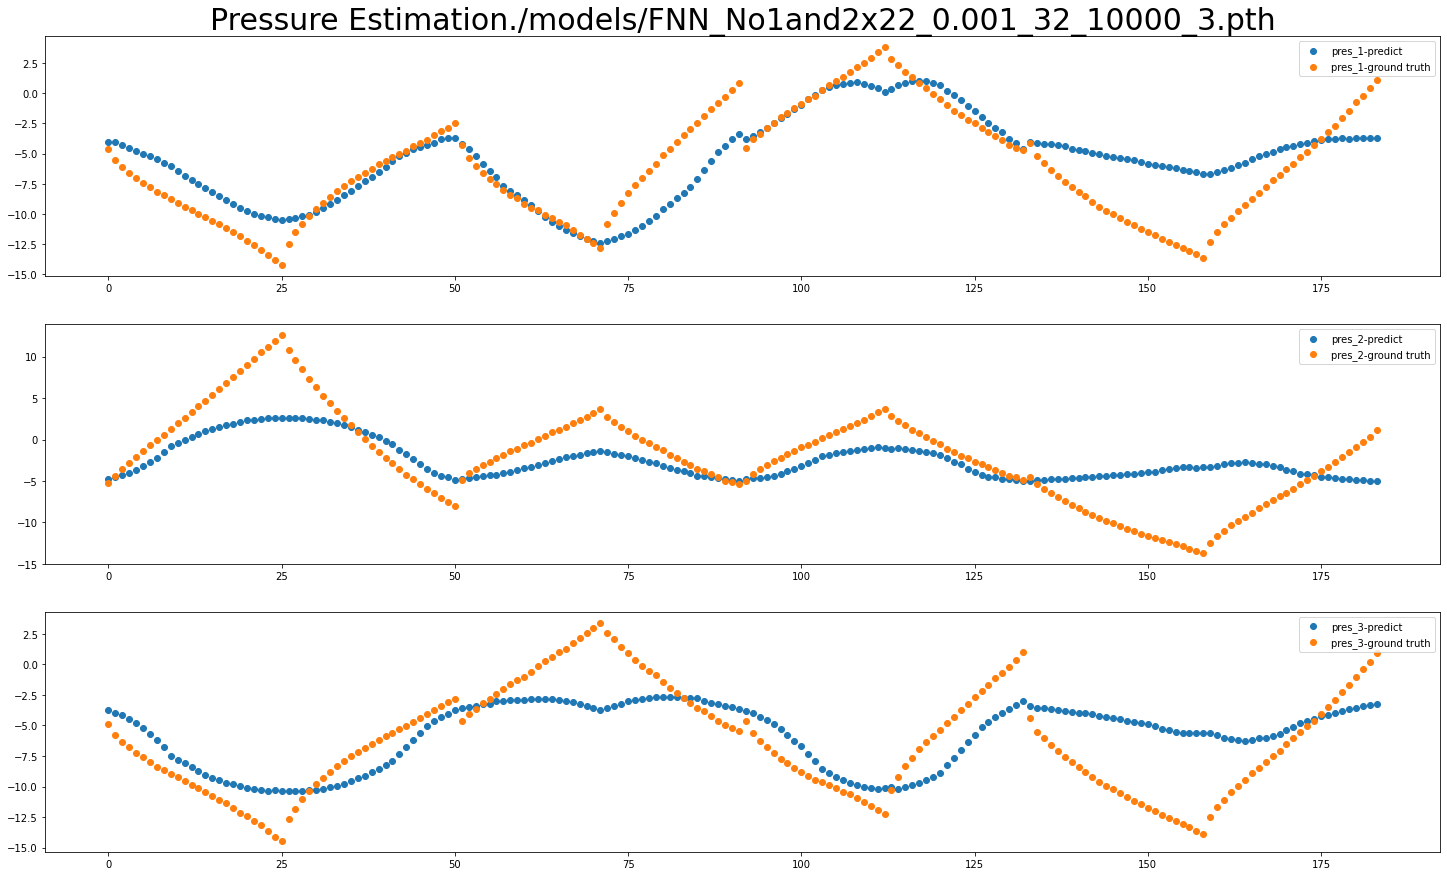

In [16]:
fig = plt.figure(figsize=(25, 15))
plt.subplot(3,1,1)
plt.scatter(np.arange(len(data_p)),data_p[:, 0],label='pres_1-predict')
plt.scatter(np.arange(len(data_p)),[x[0] for x in test_data],label='pres_1-ground truth')
plt.title('Pressure Estimation'+ str(MODEL),fontsize=30)
plt.legend()
plt.subplot(3,1,2)
plt.scatter(np.arange(len(data_p)),data_p[:, 1],label='pres_2-predict')
plt.scatter(np.arange(len(data_p)),[x[1] for x in test_data],label='pres_2-ground truth')
plt.legend()
plt.subplot(3,1,3)
plt.scatter(np.arange(len(data_p)),data_p[:, 2],label='pres_3-predict')
plt.scatter(np.arange(len(data_p)),[x[2] for x in test_data],label='pres_3-ground truth')
plt.legend()

# save the figure
fig.savefig(FIG_PATH+'/FNN_'+ str(training_set)+'_'+str(learning_rate)+'_'+str(hidden_size)+'_'+str(num_epochs)+'_'+str(num_layers)+'.png')

In [17]:
max_err = np.max(np.abs(data_p[:, :3]-[x[:3] for x in test_data]))
mean_p1_err = np.mean(np.abs(data_p[:,0]-[x[0] for x in test_data]))
mean_p2_err = np.mean(np.abs(data_p[:,1]-[x[1] for x in test_data]))
mean_p3_err = np.mean(np.abs(data_p[:,2]-[x[2] for x in test_data]))
err = np.zeros(len(data_p))
for i in range(len(data_p)):
    err[i] = np.mean(np.abs(data_p[i,:3]-[x[:3] for x in test_data][i]))
print('maximum pressure error',max_err)
print('p1 mean error:',round(mean_p1_err,2),'kpa')
print('p2 mean error:',round(mean_p2_err,2),'kpa')
print('p3 mean error:',round(mean_p3_err,2),'kpa')
print('mean error per way:',round(np.mean(err),2),'kpa') 

maximum pressure error 10.336027627438309
p1 mean error: 2.08 kpa
p2 mean error: 3.28 kpa
p3 mean error: 2.66 kpa
mean error per way: 2.67 kpa
